In [ ]:
import torch

In [ ]:
torch.cuda.is_available()  # Check if CUDA is available

In [ ]:
torch.cuda.device_count()  # Get the number of available CUDA devices

In [ ]:
import gymnasium as gym

In [ ]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

# Create the Breakout environment from the ALE (Arcade Learning Environment) namespace.
# The 'render_mode="human"' argument is what allows you to see the game window.
env = gym.make("ALE/Breakout-v5", render_mode="human")

# Reset the environment to get the initial observation.
# The 'seed' can be set for reproducibility.
observation, info = env.reset(seed=42)

# Run the environment for a total of 5 episodes.
for episode in range(5):
    print(f"--- Starting Episode: {episode + 1} ---")
    
    # Run each episode for a maximum of 1000 steps.
    for _ in range(1000):
        # The agent takes a random action from the available action space.
        action = env.action_space.sample()
        
        # The environment's step function returns new information after the action is taken.
        observation, reward, terminated, truncated, info = env.step(action)
        
        # The 'terminated' flag is True if the agent fails or the game ends (e.g., loses all lives).
        # The 'truncated' flag is True if the episode is cut short (e.g., a time limit is reached).
        if terminated or truncated:
            print(f"Episode finished!")
            # Reset the environment to start a new episode.
            observation, info = env.reset()
            # Break the inner loop to start the next episode.
            break

# Close the environment and the rendering window.
env.close()

In [ ]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

env = gym.make('ALE/Breakout-v5')
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.close()

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class FMNist_CNN(nn.Module):
    
    def __init__(self):
        super(FMNist_CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x


model = FMNist_CNN().to(device)
print(model)

Using cuda device
FMNist_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 8
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


c:\Users\User\Desktop\VS_Code_Projects\Reinforcement_learning\.venv\Lib\site-packages\torch\nn\functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


loss: 2.451858  [   64/60000]
loss: 1.986694  [ 6464/60000]
loss: 1.500421  [12864/60000]
loss: 1.327255  [19264/60000]
loss: 1.060905  [25664/60000]
loss: 1.024999  [32064/60000]
loss: 0.918887  [38464/60000]
loss: 0.802744  [44864/60000]
loss: 0.823255  [51264/60000]
loss: 0.716625  [57664/60000]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.737510 

Epoch 2
-------------------------------
loss: 0.717893  [   64/60000]
loss: 0.842814  [ 6464/60000]
loss: 0.508937  [12864/60000]
loss: 0.729200  [19264/60000]
loss: 0.644163  [25664/60000]
loss: 0.680063  [32064/60000]
loss: 0.662562  [38464/60000]
loss: 0.608378  [44864/60000]
loss: 0.643657  [51264/60000]
loss: 0.572100  [57664/60000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.589824 

Epoch 3
-------------------------------
loss: 0.517611  [   64/60000]
loss: 0.677851  [ 6464/60000]
loss: 0.386061  [12864/60000]
loss: 0.625851  [19264/60000]
loss: 0.565326  [25664/60000]
loss: 0.576663  [32064/60000]
loss: 0.551270  [38464/60000]
loss: 

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = FMNist_CNN().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    x = x.unsqueeze(0) 
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [1]:
import torch
from torch import nn
import numpy as np

In [ ]:
a = torch.FloatTensor(3, 2)

In [ ]:
a

In [ ]:
torch.zeros(3, 4)

In [ ]:
a.zero_()

In [ ]:
torch.FloatTensor([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

In [ ]:
n = np.zeros(shape=(3, 2))
n

In [ ]:
b = torch.tensor(n)
b

In [ ]:
n1 = np.zeros(shape=(3, 2),
              dtype=np.float32)
n1

In [ ]:
torch.tensor(n1)

In [ ]:
a1 = torch.FloatTensor([1, 2, 3])
a1

In [ ]:
ca1 = a1.to("cuda")
ca1

In [ ]:
a1 + 5

In [ ]:
ca1 + 5

In [ ]:
ca1.device

In [ ]:
v1 = torch.tensor([1.0, 1.0], requires_grad=True)
v2 = torch.tensor([2.0, 2.0])

In [ ]:
v_sum = v1 + v2
v_sum

In [ ]:
v_res = (v_sum * 2).sum()
v_res

In [ ]:
v1.is_leaf, v2.is_leaf, v_sum.is_leaf, v_res.is_leaf

In [ ]:
v1.requires_grad, v2.requires_grad, v_sum.requires_grad, v_res.requires_grad

In [ ]:
v_res.backward()
v1.grad, v2.grad, v_sum.grad, v_res.grad

In [2]:
l = nn.Linear(2, 5)
v = torch.FloatTensor([1, 2])
l, v

(Linear(in_features=2, out_features=5, bias=True), tensor([1., 2.]))

In [3]:
l(v)

tensor([-1.1919, -0.4569,  1.3826, -1.8124, -0.4500], grad_fn=<ViewBackward0>)

In [4]:
s = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.Dropout(p=0.3),
    nn.Softmax(dim=1)
)

In [5]:
s

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Softmax(dim=1)
)

In [7]:
s(torch.FloatTensor([[1, 2]]))

tensor([[0.0905, 0.1664, 0.0905, 0.0905, 0.0793, 0.0905, 0.0905, 0.0679, 0.1223,
         0.1116]], grad_fn=<SoftmaxBackward0>)

In [4]:
# Creating Custom module

class MyModule(nn.Module):
    def __init__(self, num_inputs, num_classes, dropout_prob=0.3):
        super(MyModule, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(num_inputs, 5),
            nn.ReLU(),
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.Dropout(p=dropout_prob),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipe(x)

In [6]:
if __name__ == "__main__":
    SNet = MyModule(num_inputs=2, num_classes=3)
    print(SNet)
    v = torch.FloatTensor([[2, 3]])
    out = SNet(v)
    print(out)
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print(f"Data from cuda: {out.to('cuda')}")

MyModule(
  (pipe): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Softmax(dim=1)
  )
)
tensor([[0.3698, 0.3151, 0.3151]], grad_fn=<SoftmaxBackward0>)
Cuda available: True
Data from cuda: tensor([[0.3698, 0.3151, 0.3151]], device='cuda:0', grad_fn=<ToCopyBackward0>)


In [2]:
x = torch.randn(1, 10)
prev_h = torch.randn(1, 20)
W_h = torch.randn(20, 20)
W_x = torch.randn(20, 10)

In [3]:
i2h = torch.mm(W_x, x.t())
h2h = torch.mm(W_h, prev_h.t())
next_h = i2h + h2h
next_h = next_h.tanh()

loss = next_h.sum()
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from tqdm import tqdm

In [ ]:
class PlayingCardDataset(Dataset):
    """A custom dataset class for loading playing card images."""
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(root=data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = PlayingCardDataset(data_dir="data/Cards/train")

In [ ]:
len(dataset)

In [ ]:
image, label = dataset[1001]

In [ ]:
image

In [ ]:
print(label)

In [ ]:
data_dir = "data/Cards/train"
target_to_class = {v: k for k, v in ImageFolder(root=data_dir).class_to_idx.items()}
target_to_class

In [ ]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
data_dir = "data/Cards/train"
dataset = PlayingCardDataset(data_dir=data_dir, transform=transform)

In [ ]:
image, label = dataset[2000]
image.shape, label

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class SimpleCardClassifier(nn.Module):
    """A simple classifier for playing cards using EfficientNet."""
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) 
        enet_out_size = 1280
        self.classiier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classiier(x)
        return x

In [ ]:
SNet = SimpleCardClassifier(num_classes=len(dataset.classes))
print(str(SNet)[:500])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(SNet.parameters(), lr=0.001)

In [ ]:
train_dataset = PlayingCardDataset("data/Cards/train", transform=transform)
valid_dataset = PlayingCardDataset("data/Cards/valid", transform=transform)
test_dataset = PlayingCardDataset("data/Cards/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Training the neural net for 7 epochs
num_epochs = 7
train_losses, val_losses = [], []
SNet.to(device)

for epoch in range(num_epochs):
    SNet.train()
    running_loss = 0.0  
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = SNet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    SNet.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = SNet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss/len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
# Compute accuracy on the test set
from sklearn.metrics import accuracy_score
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = SNet(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc * 100:.2f}%")

In [ ]:
# Test the model with a single image
SNet.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
x, y = images[1], labels[1]
with torch.no_grad():
    x = x.to(device)
    x = x.unsqueeze(0) 
    pred = SNet(x)
    predicted, actual = dataset.classes[pred[0].argmax(0)], dataset.classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download training data from open datasets.
training_data = datasets.EMNIST(
    root="data",
    split="byclass",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.EMNIST(
    root="data",
    split="byclass",
    train=False,
    download=True,
    transform=ToTensor(),
)


In [8]:
class_names = training_data.classes
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


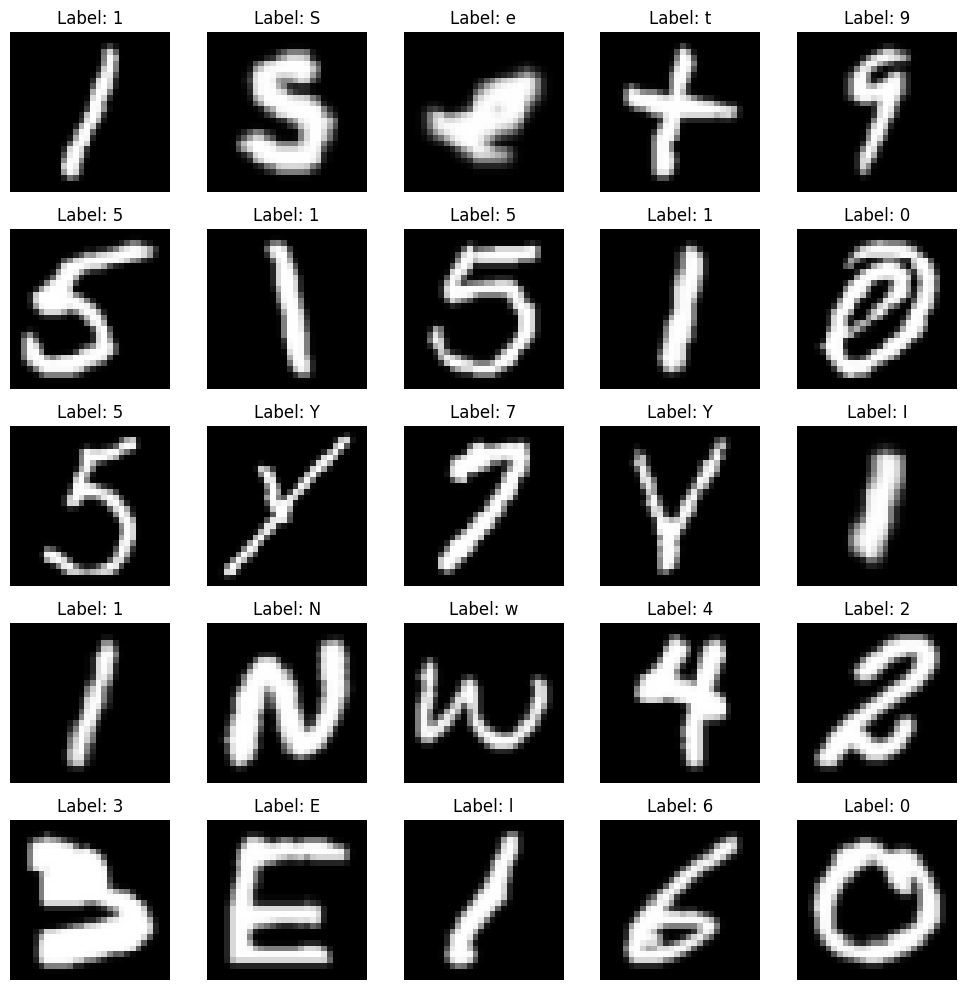

In [14]:
# Script to visualize random images from the EMNIST dataset
num_images_to_show = 25
random_indices = np.random.randint(0, len(training_data), size=num_images_to_show)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image, label = training_data[idx]
    
   
    image = image.permute(0, 2, 1)  # Transpose the image tensor
    #image = torch.flip(image, [2]) 

    # Display the image
    axes[i].imshow(image.squeeze(), cmap='gray')
    # Set the title of the subplot to the corresponding class name
    axes[i].set_title(f'Label: {class_names[label]}')
    # Turn off axis ticks
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [17]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, out_classes=62):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.adaptive = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.fc = nn.Linear(4*4*256, out_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2, 2)
        x = self.adaptive(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=4096, out_features=62, bias=True)
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.128001  [  128/697932]
loss: 4.117979  [12928/697932]
loss: 4.112479  [25728/697932]
loss: 4.110578  [38528/697932]
loss: 4.099702  [51328/697932]
loss: 4.086123  [64128/697932]
loss: 4.084318  [76928/697932]
loss: 4.074463  [89728/697932]
loss: 4.048310  [102528/697932]
loss: 4.020190  [115328/697932]
loss: 4.006731  [128128/697932]
loss: 3.938433  [140928/697932]
loss: 3.818648  [153728/697932]
loss: 3.685324  [166528/697932]
loss: 3.775425  [179328/697932]
loss: 3.631689  [192128/697932]
loss: 3.587187  [204928/697932]
loss: 3.645915  [217728/697932]
loss: 3.476231  [230528/697932]
loss: 3.641332  [243328/697932]
loss: 3.635287  [256128/697932]
loss: 3.660147  [268928/697932]
loss: 3.525511  [281728/697932]
loss: 3.420835  [294528/697932]
loss: 3.380280  [307328/697932]
loss: 3.244473  [320128/697932]
loss: 3.164767  [332928/697932]
loss: 3.023037  [345728/697932]
loss: 2.883508  [358528/697932]
loss: 2.673294  [371328/697932]
loss: 2.

In [23]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test data
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

In [24]:
# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# Move data to CPU for plotting
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

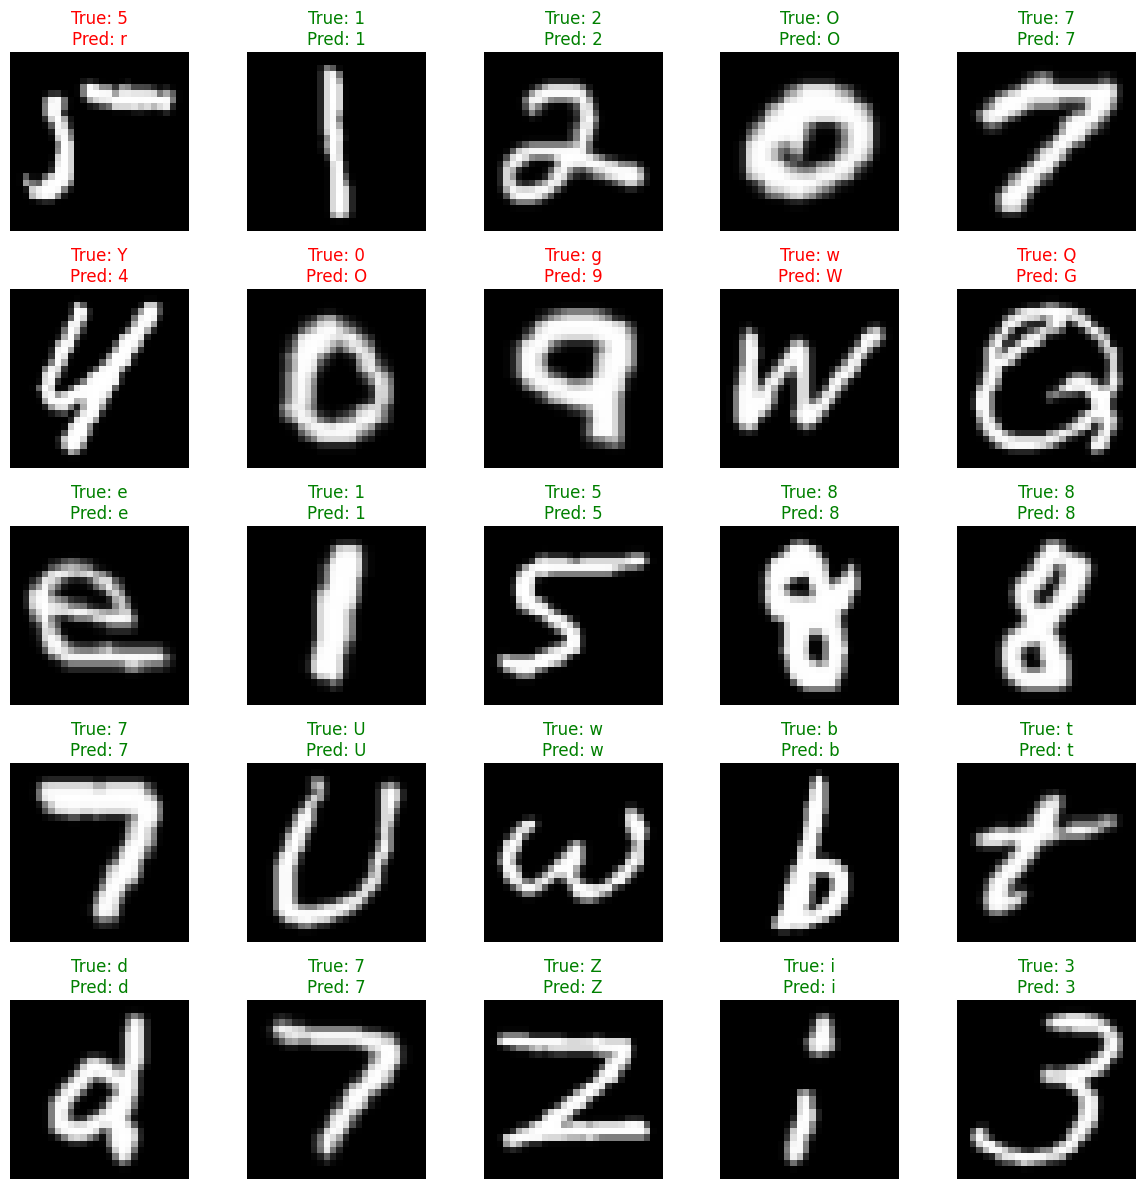

In [26]:
# Select random images to display from the batch
num_images_to_show = 25
random_indices = np.random.choice(len(images), num_images_to_show, replace=False)

# Create a plot to display the images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Get the specific image, true label, and predicted label
    image = images[idx]
    true_label_idx = labels[idx].item()
    predicted_label_idx = predicted[idx].item()

    # Correct the orientation for display 
    image_display = image.permute(0, 2, 1)
    #image_display = torch.flip(image_display, [2])

    # Display the image
    axes[i].imshow(image_display.squeeze(), cmap='gray')
    axes[i].axis('off')

    # Set title color based on prediction correctness
    true_class = class_names[true_label_idx]
    pred_class = class_names[predicted_label_idx]
    is_correct = (true_class == pred_class)
    color = "green" if is_correct else "red"
    
    axes[i].set_title(f'True: {true_class}\nPred: {pred_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()

In [1]:
import torch
from torch import nn
import torch.optim as optim

In [2]:
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
inputs = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
targets = torch.tensor([[0.], [1.], [1.], [0.]])

In [5]:
model = XORNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    outputs = model(inputs) 
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5816
Epoch [200/1000], Loss: 0.1548
Epoch [300/1000], Loss: 0.0537
Epoch [400/1000], Loss: 0.0281
Epoch [500/1000], Loss: 0.0175
Epoch [600/1000], Loss: 0.0121
Epoch [700/1000], Loss: 0.0090
Epoch [800/1000], Loss: 0.0069
Epoch [900/1000], Loss: 0.0055
Epoch [1000/1000], Loss: 0.0045


In [6]:
with torch.no_grad():
    predictions = model(inputs)
    print("\nPredictions")
    print(predictions.round())


Predictions
tensor([[0.],
        [1.],
        [1.],
        [0.]])


## Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
}

data_dir = "data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                    for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
                for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


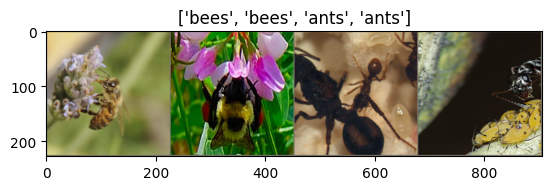

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])